# Tsodyks-Markram model of short-term synaptic plasticity
In this notebook we demonstrate how to fit the parameters of the Tsodyks-Markram model to normalized PSC amplitudes from in vitro somatic recording at different stimulation frequencies (10, 20, and 40 Hz). The in vitro amplitudes used here show a typical depressing PVBC-PVBC connection, extracted from raw traces open-sourced by Zsolt Kohus (KOKI). The original dataset is publicly available at the CRCNS site under [doi: 10.6080/K0MK69T5](https://crcns.org/data-sets/hc/hc-7)

`tmodesolve.py` implements the event-based solution of the (reduced, but) more common version of the TM model:

\begin{equation}
R_{n+1} = 1 + (R_n - R_nU_n -1)e^{-\Delta_t/D}
\end{equation}
\begin{equation}
U_{n+1} = U_{SE} + U_n(1-U_{SE})e^{-\Delta_t/F}
\end{equation}
where the $n^{th}$ amplitude is $A_{SE}U_nR_n$. This implementation fits response amplitudes recorded at different stimulation frequencies (10, 20 and 40 Hz) for better generalization.

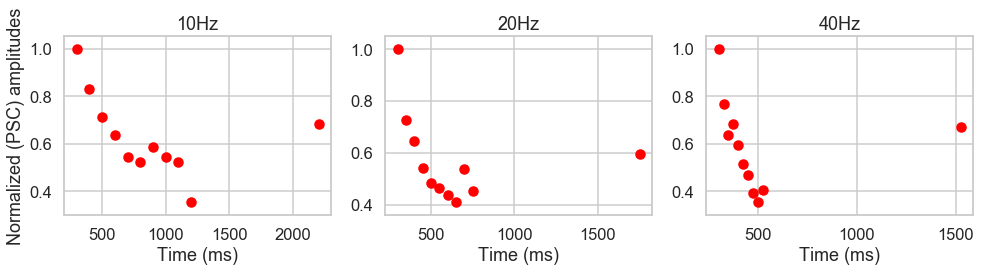

In [1]:
import pickle
from collections import OrderedDict  # not needed in Python 3
import numpy as np
import multiprocessing
import bluepyopt as bpop
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tmevaluator_multiplefreqs as tmevaluator

# Set plotting context and style
sns.set_context("talk")
sns.set_style("whitegrid")

# Load and display extracted amplitudes
with open("amps.pkl", "rb") as f:
    data = pickle.load(f)
fig = plt.figure(figsize=(14, 4))
for i, (freq, tmp) in enumerate(data.items()):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(tmp["t_spikes"], tmp["amps"], c="red")
    if i == 0:
        ax.set_ylabel("Normalized (PSC) amplitudes")
    ax.set_xlabel("Time (ms)")
    ax.set_title(freq)
fig.tight_layout()

We now estimate the parameters of the Tsodyks-Markram model using BluePyOpt.

In [2]:
# Parameters to be fitted as a list of: (name, lower bound, upper bound)
optconf = [("use", 0.01, 1.0),
           ("trec", 1.0, 2500.0),
           ("tfac", 1.0, 2500.0),
           ("ase", 1.0, 100.0)]
pnames = [name for name, _, _ in optconf]

# Create multiprocessing pool for parallel evaluation of fitness function
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

# Create BluePyOpt optimization and run 
evaluator = tmevaluator.TsodyksMarkramEvaluator(data, optconf)
opt = bpop.optimisations.DEAPOptimisation(evaluator, offspring_size=500, map_function=pool.map,
                                          eta=20, mutpb=0.3, cxpb=0.7)
pop, hof, log, history = opt.run(max_ngen=50)

# Get best individual
best = hof[0]
for pname, value in zip(pnames, best):
    print("%s = %.2f" % (pname, value))

use = 0.13
trec = 1112.32
tfac = 1.21
ase = 7.04


Finally we compare the original in vitro amplitudes with the one generated by the best model.

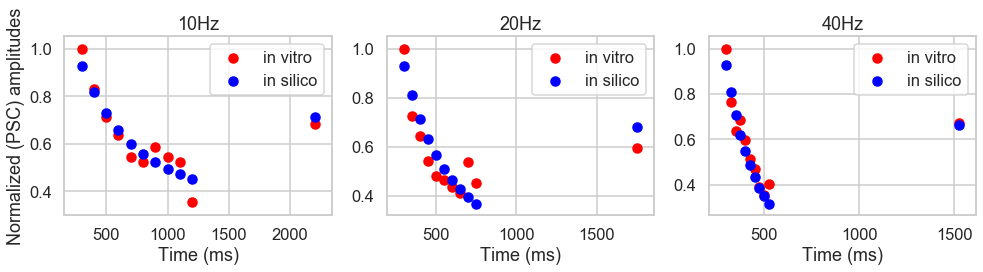

In [3]:
# Get amps (and optionally U, R state vars) for best model at every freqs.
model_amps = OrderedDict()
for freq, vals in data.items():
    amps, _ = evaluator.generate_model(freq, best)
    model_amps[freq] = amps
    
fig = plt.figure(figsize=(14, 4))
for i, (freq, tmp) in enumerate(data.items()):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(tmp["t_spikes"], tmp["amps"], c="red", label="in vitro")
    ax.scatter(tmp["t_spikes"], model_amps[freq], c="blue", label="in silico")
    if i == 0:
        ax.set_ylabel("Normalized (PSC) amplitudes")
    ax.set_xlabel("Time (ms)")
    ax.set_title(freq)
    ax.legend(loc=0)
fig.tight_layout()